<a href="https://colab.research.google.com/github/StanleyLiangYork/GAN_for_Medical_Image/blob/main/Cycle_GAN_with_Criterion_malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.6 MB/s 


In [ ]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import zipfile
import random
from PIL import Image
from matplotlib import pyplot as plt
import re
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_hub as hub
import cv2
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import pathlib

print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.8.2


Set a random seed for replication

In [ ]:
tf.random.set_seed(1000)

Fetch the malaria dataset

In [ ]:
if not os.path.exists('malaria.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/malaria.zip ./malaria.zip

with zipfile.ZipFile('malaria.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

--2022-08-18 21:16:02--  https://storage.googleapis.com/pet-detect-239118/malaria.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63432592 (60M) [application/x-zip-compressed]
Saving to: ‘malaria.zip’

malaria.zip         100%[===================>]  60.49M  50.3MB/s    in 1.2s    

2022-08-18 21:16:03 (50.3 MB/s) - ‘malaria.zip’ saved [63432592/63432592]

--2022-08-18 21:16:03--  http://./malaria.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-18 21:16:03--
Total wall clock time: 1.4s
Downloaded: 1 files, 60M in 1.2s (50.3 MB/s)


Set the folder for the different image classes

In [ ]:
data_dir = './malaria'
data_dir = pathlib.Path(data_dir)
blood_imgs = list(data_dir.glob('*/*.png'))

print(f'There are {len(blood_imgs)} in total.')

There are 24820 in total.


In [ ]:
positive_paths = []
negative_paths = []
for file in blood_imgs:
  file = str(file)
  parts = tf.strings.split(file, os.path.sep)
  if parts[-2] == 'Parasitemic':
    positive_paths.append('/content/'+file)
  else:
    negative_paths.append('/content/'+file)

randomly select 2000 images from each class for test, note that we will use the images in the test dataset to train the GAN

In [ ]:
total = len(positive_paths)
test_idx = np.random.choice(total, 2000, replace=False)

# move the images to their correspoding folders
positive_paths = np.array(positive_paths)
negative_paths = np.array(negative_paths)
test_positive = np.take(positive_paths, test_idx, axis=0)
train_positive = np.delete(positive_paths, test_idx, axis=0)
test_negative = np.take(negative_paths, test_idx, axis=0)
train_negative = np.delete(negative_paths, test_idx, axis=0)

train_images = np.concatenate((train_positive, train_negative), axis=0)
test_images = np.concatenate((test_positive, test_negative), axis=0)
print(train_images.shape)
print(test_images.shape)

(20820,)
(4000,)


Setup the folders for the following tasks

In [ ]:
if not os.path.exists('train'):
  os.mkdir('train')

if not os.path.exists('test'):
  os.mkdir('test')

os.mkdir('train/Parasitemic')
os.mkdir('test/Parasitemic')
os.mkdir('train/Uninfected')
os.mkdir('test/Uninfected')

for file in train_images:
  parts = str.split(file, os.path.sep)
  cp_path = parts[-2]+'/'+parts[-1]
  root = '/content/train'+'/'
  dest = root+cp_path
  src = file
  shutil.copy2(src, dest)

for file in test_images:
  parts = str.split(file, os.path.sep)
  cp_path = parts[-2]+'/'+parts[-1]
  root = '/content/test'+'/'
  dest = root+cp_path
  src = file
  shutil.copy2(src, dest)

Set the helper functions for image processing

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32, 32])

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  if parts[-2] == 'Parasitemic':
    return tf.constant(1.0, dtype="float64")
  else:
    return tf.constant(0.0, dtype="float64")


def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  # rescale from (0,255) to (-1,1)
  img = (img - 127.5) / 127.5
  return img, label

In [ ]:
# setup the dataset iterator for positive / negative 
BATCH_SIZE = 512
train_BUFFER_SIZE = 20820
test_BUFFER_SIZE = 4000

train_dataset = tf.data.Dataset.list_files("/content/train/*/*.png")
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(train_BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files("/content/test/*/*.png")
test_dataset = test_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(test_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
images, labels = next(iter(test_dataset))
print(images.shape)
print(labels.shape)

(512, 32, 32, 3)
(512,)


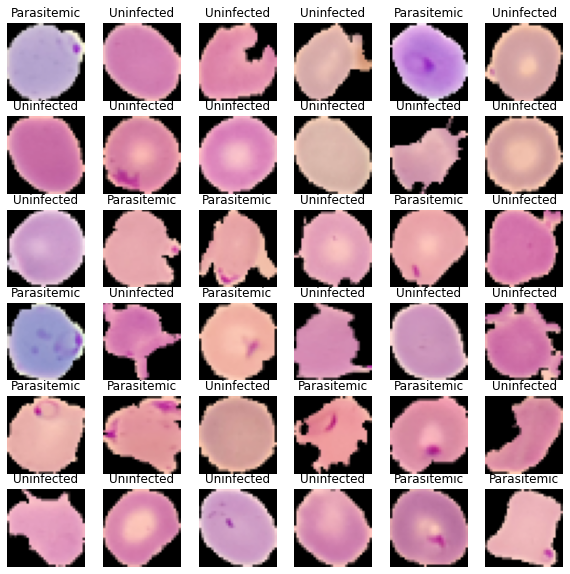

In [ ]:
plt.figure(figsize=(10,10))
title=['Parasitemic', 'Uninfected']
for i in range(6 * 6):
  plt.subplot(6, 6, 1 + i)
  plt.axis(False)
  image = tf.keras.preprocessing.image.array_to_img(images[i])
  # plt.title(title[np.argmax(labels[i])])
  if labels[i] == 1:
    plt.title(title[0])
  else:
    plt.title(title[1])
  plt.imshow(image)
plt.show()

Define and train the classifier

In [ ]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = tfkl.Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = tfkl.Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = tfkl.Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = tfk.layers.Add()([conv2, merge_input])
	# activation function
	layer_out = tfkl.Activation('relu')(layer_out)
	return layer_out

In [ ]:
def define_classifier(input_dim=(32,32,3)):
  input_layer = tfk.Input(shape=input_dim)
  layer = tfkl.Lambda(lambda x: x*127.5+127.5)(input_layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = tfkl.Flatten()(layer)
  layer = tfkl.Dense(128, activation='tanh')(layer)
  layer = tfkl.Dropout(0.4)(layer)
  layer = tfkl.Dense(128, activation='tanh')(layer)
  layer = tfkl.Dropout(0.4)(layer)
  layer = tfkl.Dense(2)(layer)
  model = tfk.models.Model(inputs=input_layer, outputs=layer)
  return model

In [ ]:
classifier = define_classifier()
classifier.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_4 (Lambda)              (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 32, 32, 64)   1792        ['lambda_4[0][0]']               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_29[0][0]']              
                                                                                            

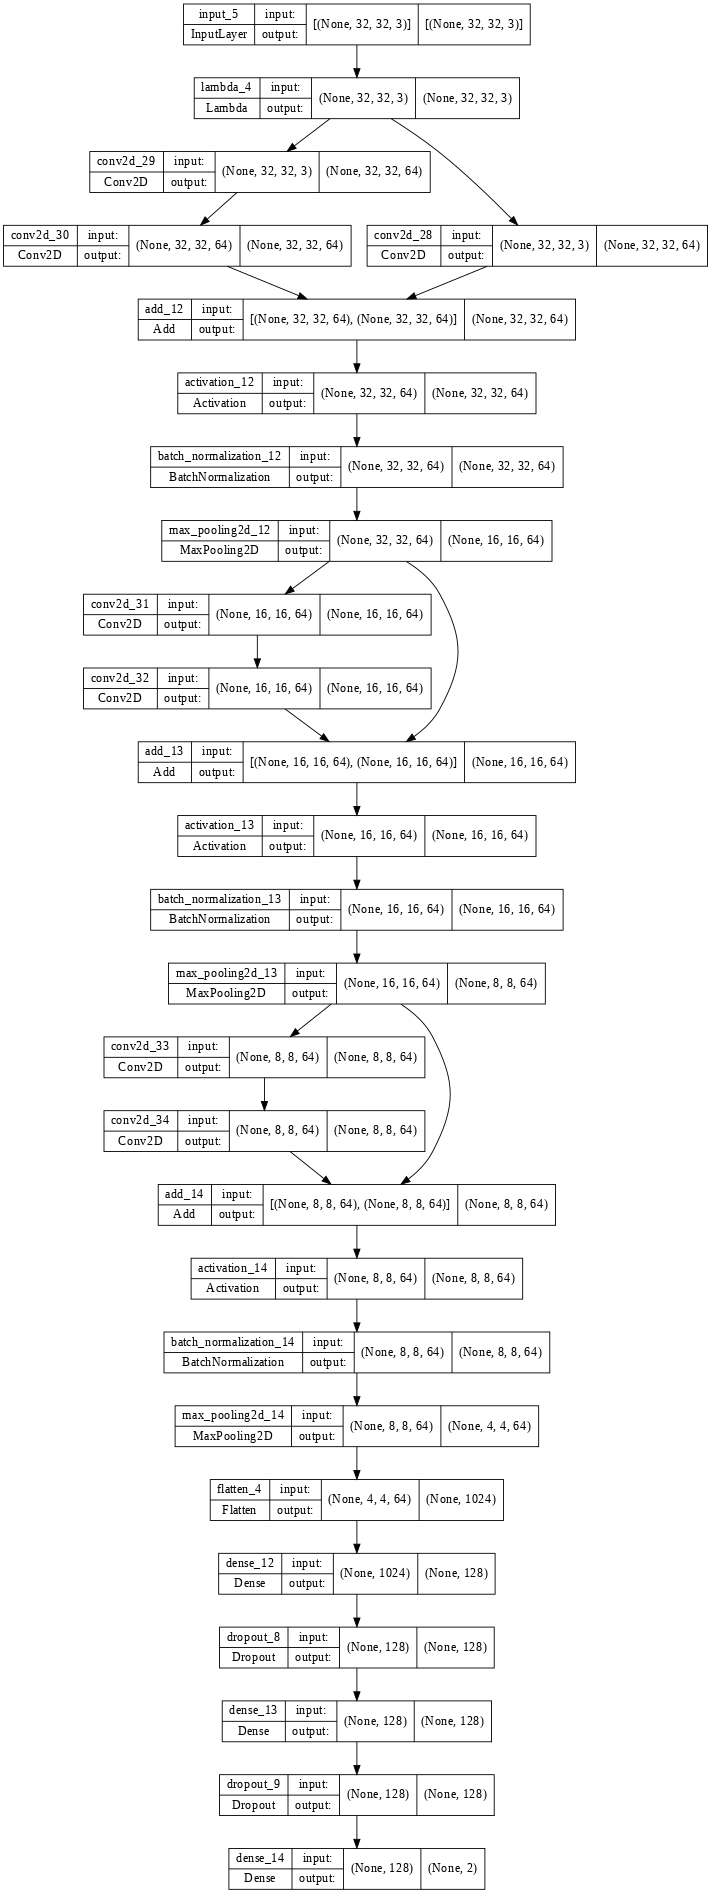

In [ ]:
tfk.utils.plot_model(classifier, show_shapes=True, dpi=64)

In [ ]:
classifier.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history = classifier.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[callback], verbose=2)

Epoch 1/100
41/41 - 11s - loss: 0.7383 - accuracy: 0.6142 - val_loss: 0.6914 - val_accuracy: 0.5487 - 11s/epoch - 277ms/step
Epoch 2/100
41/41 - 10s - loss: 0.5376 - accuracy: 0.7467 - val_loss: 0.9825 - val_accuracy: 0.5167 - 10s/epoch - 248ms/step
Epoch 3/100
41/41 - 10s - loss: 0.4439 - accuracy: 0.7973 - val_loss: 1.7012 - val_accuracy: 0.5013 - 10s/epoch - 251ms/step
Epoch 4/100
41/41 - 10s - loss: 0.3408 - accuracy: 0.8481 - val_loss: 2.5201 - val_accuracy: 0.5002 - 10s/epoch - 247ms/step
Epoch 5/100
41/41 - 10s - loss: 0.2636 - accuracy: 0.8882 - val_loss: 2.7778 - val_accuracy: 0.5025 - 10s/epoch - 252ms/step
Epoch 6/100
41/41 - 10s - loss: 0.2209 - accuracy: 0.9074 - val_loss: 1.7888 - val_accuracy: 0.5347 - 10s/epoch - 250ms/step
Epoch 7/100
41/41 - 11s - loss: 0.1853 - accuracy: 0.9260 - val_loss: 1.6499 - val_accuracy: 0.5455 - 11s/epoch - 280ms/step
Epoch 8/100
41/41 - 10s - loss: 0.1454 - accuracy: 0.9428 - val_loss: 1.7717 - val_accuracy: 0.5785 - 10s/epoch - 254ms/step


In [ ]:
classifier.evaluate(test_dataset)

8/8 [==============================] - 3s 38ms/step - loss: 0.1811 - accuracy: 0.9613


[0.18107998371124268, 0.9612500071525574]

Text(0.5, 0, 'epoch')

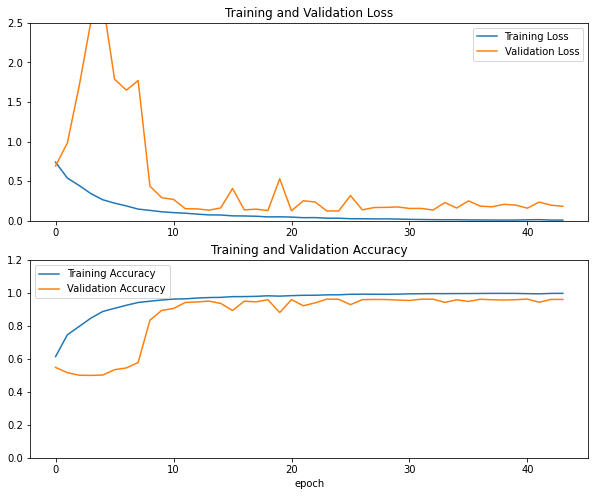

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim([0, 2.5])
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim([0, 1.2])
plt.plot()
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

Save the trained model, you can zip and copy it to you google drive by uncommenting the code below

In [ ]:
classifier.save('classify_malaria_32')

!zip -r classify_malaria_32.zip classify_malaria_32

  adding: classify_malaria_32/ (stored 0%)
  adding: classify_malaria_32/keras_metadata.pb (deflated 93%)
  adding: classify_malaria_32/saved_model.pb (deflated 90%)
  adding: classify_malaria_32/assets/ (stored 0%)
  adding: classify_malaria_32/variables/ (stored 0%)
  adding: classify_malaria_32/variables/variables.index (deflated 75%)
  adding: classify_malaria_32/variables/variables.data-00000-of-00001 (deflated 8%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil

source = "/content/classify_malaria_64.zip"
destination = "/content/drive/MyDrive/classify_malaria_64.zip"
shutil.copy2(source, destination)

Mounted at /content/drive


'/content/drive/MyDrive/classify_malaria_64.zip'

If a trained classifier has been saved on google drive, skip the training and uncomment the following cell

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import shutil

# destination = "/content/classify_malaria_64.zip"
# source = "/content/drive/MyDrive/classify_malaria_64.zip"
# shutil.copy2(source, destination)

Now we setup the Cycle-GAN with criterion

In [ ]:
# delete and reload the pretrained classifier
del classifier
classifier = tfk.models.load_model('classify_malaria_64')
classifier.trainable = False

In [ ]:
# check the pretrained classifier with the validation dataset
classifier.evaluate(test_dataset)

16/16 [==============================] - 2s 31ms/step - loss: 0.2157 - accuracy: 0.9485


[0.21572919189929962, 0.9484999775886536]

In [ ]:
class_loss = tfk.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
def get_accuracy(g_true, preds):
  pred_idx = tf.argmax(preds, axis=1).numpy()
  count = 0
  for tab, pred in zip(g_true, pred_idx):
    if tab == pred:
      count += 1
  return count / preds.shape[0]

In [ ]:
preds = classifier(images)

In [ ]:
result = get_accuracy(labels, preds)
print(result)

0.921875


In [ ]:
loss = class_loss(labels, preds)
print(loss)

tf.Tensor(0.32682726, shape=(), dtype=float32)


In [ ]:
# define the discriminator model based on Patch 
def define_discriminator(image_shape=(64,64,3)):
  init = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
  in_image = tf.keras.Input(shape=image_shape)
  d = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image) # 32*32*64
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 16*16*128
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 8*8*256
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 4*4*512
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d) # 4*4*512
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  patch_out = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d) # 4*4*1
  model = tf.keras.Model(inputs=in_image, outputs=patch_out)
  return model

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tfkl.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tfkl.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def define_generator():
  inputs = tf.keras.layers.Input(shape=[64, 64, 3])

  down_stack = [
    downsample(64, 4),  # (bs, 32, 32, 64)
    downsample(128, 4),  # (bs, 16, 16, 128)
    downsample(256, 4),  # (bs, 8, 8, 256)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4),  # (bs, 2, 2, 1024)
    upsample(512, 4),  # (bs, 4, 4, 1024)
    upsample(256, 4),  # (bs, 8, 8, 512)
    upsample(128, 4),  # (bs, 16, 16, 256)
    upsample(64, 4),  # (bs, 32, 32, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 64, 64, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
image_shape = (64,64,3)

generator_g = define_generator()
generator_f = define_generator()
discriminator_x = define_discriminator(image_shape)
discriminator_y = define_discriminator(image_shape)

In [ ]:
discriminator_x.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 instance_normalization_22 (  (None, 16, 16, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                           

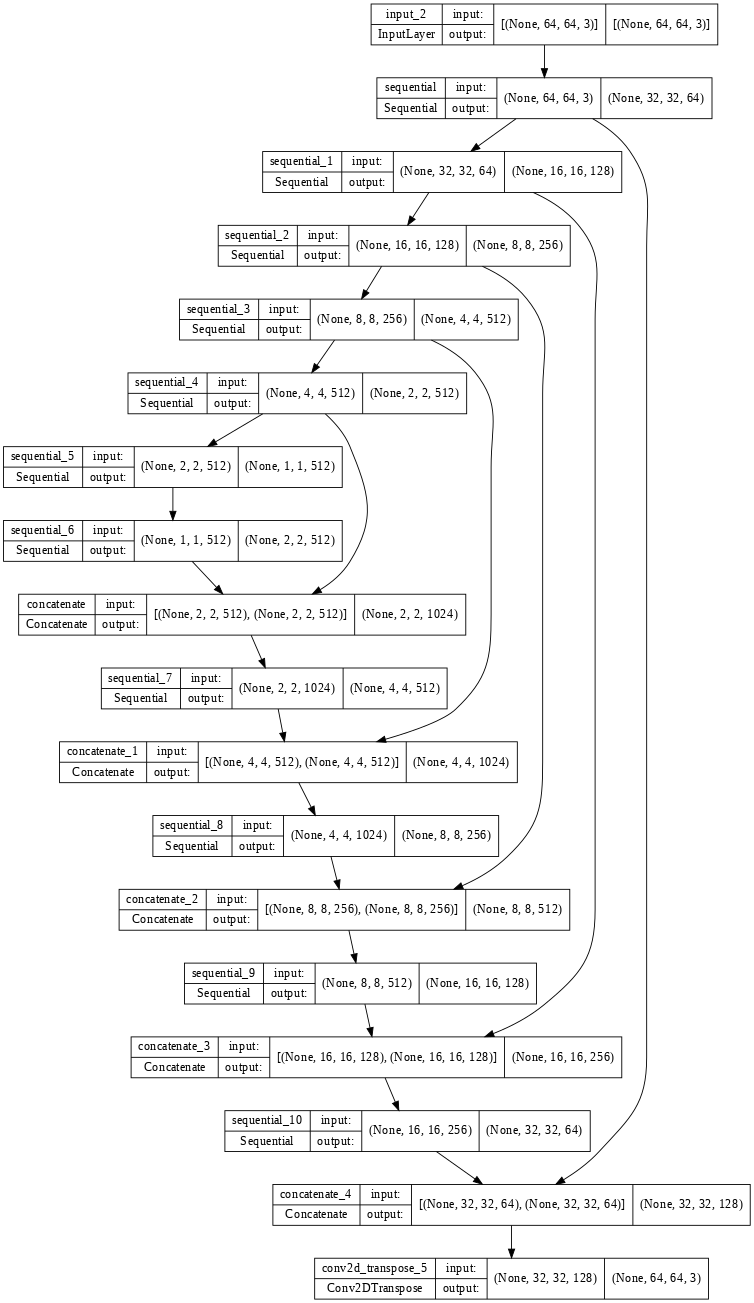

In [ ]:
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

Setup the image dataset for GAN optimization

In [ ]:
positive_ds = tf.data.Dataset.list_files("/content/train/Parasitemic/*.png")
negative_ds = tf.data.Dataset.list_files("/content/train/Uninfected/*.png")

In [ ]:
def process_gan_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = (img - 127.5) / 127.5
  return img

In [ ]:
BUFFER_SIZE = 2000
BATCH_SIZE = 128

positive_ds = positive_ds.map(process_gan_path,  num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
negative_ds = negative_ds.map(process_gan_path,  num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

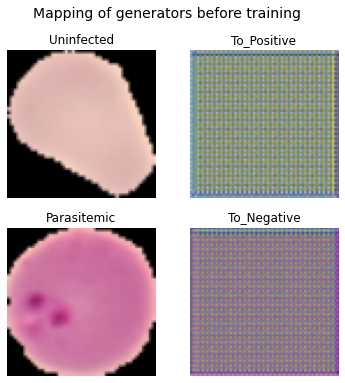

In [ ]:
# x -> y: negative -> positive - generator_g
# y -> x: positive -> negative - generator_f

p_images = next(iter(positive_ds))
n_images = next(iter(negative_ds))

to_positive = generator_g(n_images)
to_negative = generator_f(p_images)
plt.figure(figsize=(6, 6))

imgs = [n_images, to_positive, p_images, to_negative]
title = ['Uninfected', 'To_Positive', 'Parasitemic', 'To_Negative']

plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[0][0]))
plt.suptitle("Mapping of generators before training", fontsize=14)
for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  plt.axis(False)
  if i % 2 == 0:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
  else:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
plt.show()

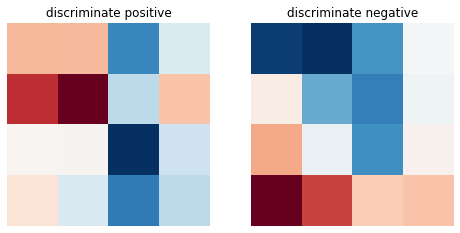

In [ ]:
# the hotmap of untrained discriminator
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title('discriminate positive')
plt.axis(False)
plt.imshow(discriminator_y(p_images)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('discriminate negative')
plt.axis(False)
plt.imshow(discriminator_x(n_images)[0, ..., -1], cmap='RdBu_r')
plt.show()

Define the loss functions for the GAN components

In [ ]:
LAMBDA = 80
# alternative: MSE
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# loss_obj = tfk.losses.MeanSquaredError()

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5


def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

# prevser color
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
  idx = int(np.random.choice(16, 1, replace=False))
  plt.figure(figsize=(10, 10))
  

  display_list = [test_input[idx], prediction[idx]]
  title = ['Input Image', 'Generated Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def classify_positive_loss(y, batch_size):
  true_positive = tf.ones([batch_size,1])
  pred_y = classifier(y)
  return class_loss(true_positive, pred_y)


@tf.function
def classify_negative_loss(x, batch_size):
  true_negative = tf.zeros([batch_size,1])
  pred_x = classifier(x)
  return class_loss(true_negative, pred_x)

In [ ]:
@tf.function
def train_step(real_x, real_y, c_flag=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  batch_size = real_x.shape[0]
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    # calculate classifier loss
    # true_normal = tf.ones([batch_size,])
    # true_covid = tf.zeros([batch_size,])
    pred_same_x = classifier(same_x)
    pred_same_y = classifier(same_y)
    pred_cycled_x = classifier(cycled_x)
    pred_cycled_y = classifier(cycled_y)

    c_loss_x = classify_negative_loss(same_x, batch_size) + classify_negative_loss(cycled_x, batch_size)
    c_loss_x = c_loss_x * 0.4
    
    c_loss_y = classify_positive_loss(same_y, batch_size) + classify_positive_loss(cycled_y, batch_size)
    c_loss_y = c_loss_y * 0.4

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    if (c_flag):
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + c_loss_y
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + c_loss_x
    else:
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

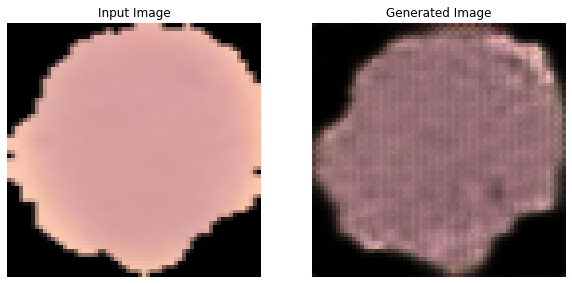

Saving checkpoint for epoch 300 at ./checkpoints/train/ckpt-60
Time taken for epoch 300 is 85.38783192634583 sec



In [ ]:
import time
from IPython.display import clear_output
from IPython import display

history = {}
history['class_loss_x'] = []
history['class_loss_y'] = []
history['cycle_loss'] = []
history['total_gen_g_loss'] = []
history['total_gen_f_loss'] = []
history['disc_loss_x'] = []
history['disc_loss_y'] = []

c_loss_x_mean = tfk.metrics.Mean()
c_loss_y_mean = tfk.metrics.Mean()
cycle_loss_mean = tfk.metrics.Mean()
total_gen_g_loss_mean = tfk.metrics.Mean()
total_gen_f_loss_mean = tfk.metrics.Mean()
disc_loss_x_mean = tfk.metrics.Mean()
disc_loss_y_mean = tfk.metrics.Mean()


for epoch in range(300):
  start = time.time()
  c_loss_x_mean.reset_state()
  c_loss_y_mean.reset_state()
  cycle_loss_mean.reset_state()
  total_gen_g_loss_mean.reset_state()
  total_gen_f_loss_mean.reset_state()
  disc_loss_x_mean.reset_state()
  disc_loss_y_mean.reset_state()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((negative_ds, positive_ds)):
    if (n % 5 == 0):
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, c_flag=True) # chang c_flag to False if want to remove the criterion
    else:
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, c_flag=False)
    c_loss_x_mean.update_state(c_loss_x)
    c_loss_y_mean.update_state(c_loss_y)
    cycle_loss_mean.update_state(total_cycle_loss)
    total_gen_g_loss_mean.update_state(total_gen_g_loss)
    total_gen_f_loss_mean.update_state(total_gen_f_loss)
    disc_loss_x_mean.update_state(disc_x_loss)
    disc_loss_y_mean.update_state(disc_y_loss)

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, n_images)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
  history['class_loss_x'].append(c_loss_x_mean.result().numpy())
  history['class_loss_y'].append(c_loss_y_mean.result().numpy())
  history['cycle_loss'].append(cycle_loss_mean.result().numpy())
  history['total_gen_g_loss'].append(total_gen_g_loss_mean.result().numpy())
  history['total_gen_f_loss'].append(total_gen_f_loss_mean.result().numpy())
  history['disc_loss_x'].append(disc_loss_x_mean.result().numpy())
  history['disc_loss_y'].append(disc_loss_y_mean.result().numpy())

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
# save the trained 
generator_g.save('malariaCell_generator_64')
!zip -r malariaCell_generator_64.zip malariaCell_generator_64

Visualize the loss values of the generators and discriminators

Text(0.5, 0, 'epoch')

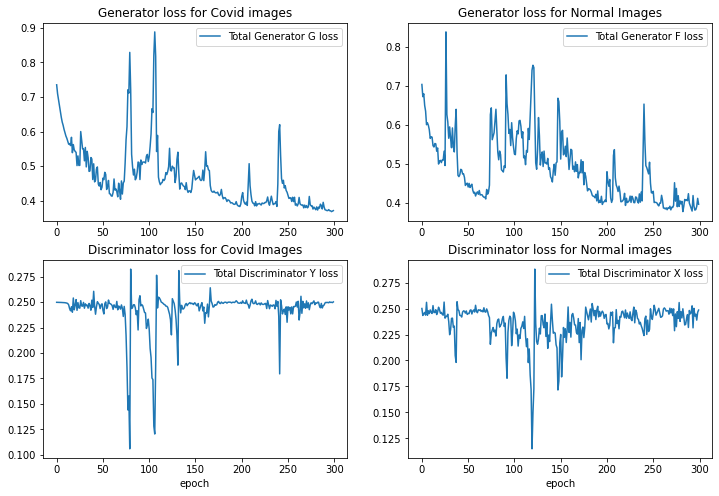

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history['total_gen_g_loss'], label='Total Generator G loss')
plt.legend(loc='best')
plt.title('Generator loss for Covid images')
# plt.xlabel('epoch')

plt.subplot(2, 2, 2)
plt.plot(history['total_gen_f_loss'], label='Total Generator F loss')
plt.plot()
plt.legend(loc='best')
plt.title('Generator loss for Normal Images')
# plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(history['disc_loss_y'], label='Total Discriminator Y loss')
# plt.ylim([0, 0.02])
plt.plot()
plt.legend(loc='best')
plt.title('Discriminator loss for Covid Images')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(history['disc_loss_x'], label='Total Discriminator X loss')
# plt.ylim([0, 0.02])
plt.plot()
plt.legend(loc='best')
plt.title('Discriminator loss for Normal images')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

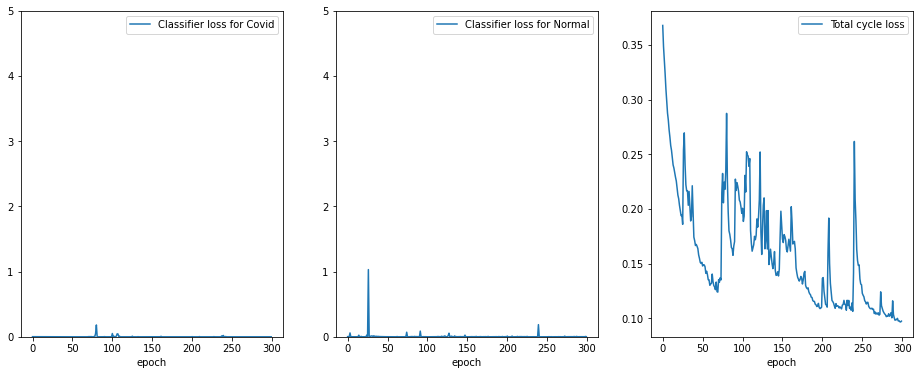

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(history['class_loss_y'], label='Classifier loss for Covid')
# plt.plot(history['total_gen_g_loss'], label='Generator loss for positive')
plt.ylim([0, 5.0])
plt.legend(loc='best')
# plt.title('Classifier and Generator Loss for Covid')
plt.xlabel('epoch')

plt.subplot(1, 3, 2)
plt.plot(history['class_loss_x'], label='Classifier loss for Normal')
# plt.plot(history['total_gen_f_loss'], label='Generator loss for negative')
plt.ylim([0, 5.0])
plt.plot()
plt.legend(loc='best')
# plt.title('Classifier and Generator Loss for Normal')
plt.xlabel('epoch')

plt.subplot(1, 3, 3)
plt.plot(history['cycle_loss'], label='Total cycle loss')
# plt.ylim([0, 2.5])
plt.plot()
plt.legend(loc='best')
# plt.title('Total cycle loss')
plt.xlabel('epoch')

In [ ]:
g_loss = history['total_gen_g_loss']
g_loss = np.array(g_loss)
print(f'Generator G Loss -- Mean: {g_loss.mean()}, Std: {g_loss.std()}, Max: {g_loss.max()}, Min: {g_loss.min()}')

f_loss = history['total_gen_f_loss']
f_loss = np.array(f_loss)
print(f'Generator F Loss -- Mean: {f_loss.mean()}, Std: {f_loss.std()}, Max: {f_loss.max()}, Min: {f_loss.min()}')

Generator G Loss -- Mean: 0.4637284278869629, Std: 0.08727525919675827, Max: 0.8882405161857605, Min: 0.3683713972568512
Generator F Loss -- Mean: 0.4864019751548767, Std: 0.08430851995944977, Max: 0.8375925421714783, Min: 0.37826019525527954


In [ ]:
disc_loss_x = history['disc_loss_x']
disc_loss_x = np.array(disc_loss_x)
print(f'Discriminator X Loss -- Mean: {disc_loss_x.mean()}, Std: {disc_loss_x.std()}, Max: {disc_loss_x.max()}, Min: {disc_loss_x.min()}')

disc_loss_y = history['disc_loss_y']
disc_loss_y = np.array(disc_loss_y)
print(f'Discriminator Y Loss -- Mean: {disc_loss_y.mean()}, Std: {disc_loss_y.std()}, Max: {disc_loss_y.max()}, Min: {disc_loss_y.min()}')

Discriminator X Loss -- Mean: 0.23674586415290833, Std: 0.016991307958960533, Max: 0.2880435883998871, Min: 0.11488935351371765
Discriminator Y Loss -- Mean: 0.2429579347372055, Std: 0.018902434036135674, Max: 0.2822985053062439, Min: 0.10600478202104568


In [ ]:
cycle_loss = history['cycle_loss']
cycle_loss = np.array(cycle_loss)
print(f'Cycle loss -- Mean: {cycle_loss.mean()}, Std: {cycle_loss.std()}, Max: {cycle_loss.max()}, Min: {cycle_loss.min()}')

Cycle loss -- Mean: 0.15903455018997192, Std: 0.051865655928850174, Max: 0.36772653460502625, Min: 0.09654280543327332


In [ ]:
classify_x_loss = history['class_loss_x']
classify_x_loss = np.array(classify_x_loss)
print(f'Classify Negative Image loss -- Mean: {classify_x_loss.mean()}, Std: {classify_x_loss.std()}, Max: {classify_x_loss.max()}, Min: {classify_x_loss.min()}')

classify_y_loss = history['class_loss_y']
classify_y_loss = np.array(classify_y_loss)
print(f'Classify Positive Image loss -- Mean: {classify_y_loss.mean()}, Std: {classify_y_loss.std()}, Max: {classify_y_loss.max()}, Min: {classify_y_loss.min()}')

Classify Negative Image loss -- Mean: 0.007117350120097399, Std: 0.06069611385464668, Max: 1.0302728414535522, Min: 7.64809283282375e-06
Classify Positive Image loss -- Mean: 0.001816176576539874, Std: 0.01185677945613861, Max: 0.18157412111759186, Min: 8.57681811794464e-07


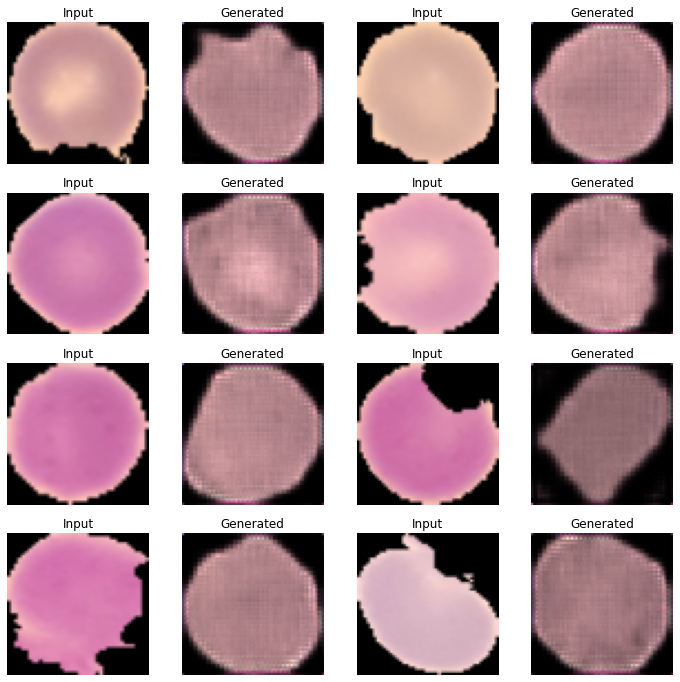

In [ ]:
negative_images = next(iter(negative_ds))
g_image = generator_g(negative_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(negative_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(g_image[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [ ]:
g_true = tf.ones([64,1]) # 0 - positive imagess
preds = classifier(g_image)
acc = get_accuracy(g_true, preds)
print(f'{acc * 100}% of generated images are classified as malaria positive')
preds_negative = classifier(negative_images)
l_normal = tf.zeros([64, 1])
acc_2 = get_accuracy(l_normal, preds_negative)
print(f'{acc_2*100}% of real normal images are classified as normal')

50.0% of generated images are classified as malaria positive
46.875% of real normal images are classified as normal
